# Imports

In [ ]:
!pip install stable_baselines3
!pip install shimmy>=0.2.1

In [63]:
import gym
from gym import spaces
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Environment Setup

In [79]:
class TemperatureControlEnv(gym.Env):
    """
    Gym Environment for Simulating Temperature Stabilization of a Test Mass.

    This environment models a system governed by a differential equation. It is designed for reinforcement learning
    tasks where the goal is to control the system's temperature by adjusting the heating rate. The environment provides
    observations of the current temperature and the environmental temperature, and it allows actions to control the heating
    rate.

    Parameters:
        - initial_temperature (float): The initial temperature of the system.
        - eta (float): Efficiency factor representing the fraction of heat delivered to the system.
        - h (float): Convective heat transfer coefficient.
        - m (float): Mass of the system object.
        - S (float): Total surface area of the object exposed to the environment.
        - desired_temp (float): The temperature you want to maintain (default is 40 deg)
        - time_step_duration (int): Duration of each time step in seconds (default is 10 seconds).
        - max_time_hours (int): Maximum simulation time in hours (default is 50 hours).

    Observation Space:
        - Two values representing the current temperature and the environmental temperature.

    Action Space:
        - A single action representing the heating rate.

    Reward:
        - The reward is based on the squared error between the current temperature and a reference temperature (desired_temp).

    Methods:
        - step(action): Perform a time step by applying the given action.
        - reset(): Reset the environment to its initial state.
        - render(mode='human'): Render the environment (not implemented).
        - close(): Close the environment (not implemented).
        - get_Tenv(): Emulates the process of receiving a reading of the environmental temperature.

    """

    def __init__(self, initial_temperature, eta, h, m, S, desired_temp=40, initial_Tenv = 20, time_step_duration=10, max_time_hours=50):
        """Initialize the environment."""

        super(TemperatureControlEnv, self).__init__()

        # Variables of the system
        self.eta = eta
        self.h = h
        self.m = m
        self.S = S
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.desired_temp = desired_temp

        self.time_step = 0

        self.action_space = spaces.Box(low=0.0, high=2.0, shape=(1,), dtype=np.float32)  # Action space for heating rate H
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(2,), dtype=np.float32)  # Observation space for (current temperature, Tenv)

        # Define time step and maximum time
        self.time_step_duration = time_step_duration  # 10 seconds per time step
        self.max_time_hours = max_time_hours  # Maximum time in hours
        self.max_time_steps = int((self.max_time_hours * 3600) / self.time_step_duration)

        # Initial Environment Temp.
        self.initial_Tenv = initial_Tenv
        self.Tenv = self.initial_Tenv

    def step(self, action):
        """
        Perform a time step in the environment by applying the given action.

        Args:
            action (array-like): A single action representing the heating rate.

        Returns:
            observation (array): An array representing the current temperature and environmental temperature.
            reward (float): The reward for the current time step.
            done (bool): True if the episode is complete, False otherwise.
            info (dict): Additional information (not used in this implementation).
        """

        # Receives a "reading" of the environment temperature
        self.Tenv = self.get_Tenv()

        # Implementation of the differential equation modeling the system
        T = self.current_temperature
        etaH = self.eta * action[0] * self.time_step_duration  # Scale by time_step_duration
        hS = self.h * self.S * self.time_step_duration  # Scale by time_step_duration
        delta_T = etaH - hS * (T - self.Tenv)
        self.current_temperature += delta_T
        self.time_step += 1

        # Define the reward function as negative squared error between desired and current temperature
        reward = -((self.current_temperature - self.desired_temp) ** 2)

        # Check if the episode is done
        done = self.time_step >= self.max_time_steps

        # Creates the observation space
        observation = np.array([self.current_temperature, self.Tenv])

        return observation, reward, done, {}

    def reset(self):
        """
        Reset the environment to its initial state.

        Returns:
            observation (array): An array representing the initial current temperature and environmental temperature.
        """

        self.current_temperature = self.initial_temperature
        self.Tenv = self.initial_Tenv
        self.time_step = 0
        observation = np.array([self.current_temperature, self.Tenv])
        return observation

    def render(self):
        """ Render the environment (not implemented). """
        pass

    def close(self):
        """Close the environment (not implemented). """

        pass

    def get_Tenv(self):
        """
        Emulates the process of receiving a reading of the environmental temperature.

        This method models the environmental temperature variation as a combination of sinusoidal macro variation and microvariations.
        It calculates the current environmental temperature and returns it.

        Returns:
            float: The updated environmental temperature.
        """

        amplitude = 0.5  # Amplitude of the sinusoidal variation (degrees C)
        period_hours = 12  # Period of the sinusoidal variation (hours)
        noise_stddev = 0.0  # Standard deviation of noise (degrees C)

        # Calculate the time in hours
        time_hours = self.time_step * self.time_step_duration / 3600

        # Calculate the macro variation using a sine wave
        macro_variation = amplitude * np.sin(2 * np.pi * time_hours / period_hours)

        # Generate microvariations with noise
        # microvariations = np.random.normal(scale=noise_stddev)

        # Combine macro and micro variations
        tenv = self.initial_Tenv + macro_variation #+ microvariations

        return tenv


In [80]:
# Creates a puck system

initial_temperature = 20  # Initial puck temperature
eta = 0.725  # Efficiency factor
h = 3.813  # Convective heat transfer coefficient
m = 0.298  # Mass of the puck (kg)
S = 0.00456  # Surface area of a puck face (m^2)

# Create the Differential Equation environment with the specified parameters
env = TemperatureControlEnv(initial_temperature, eta, h, m, S)

Examining the environmental temperature and maximum puck temperature at full power (2 Watts)

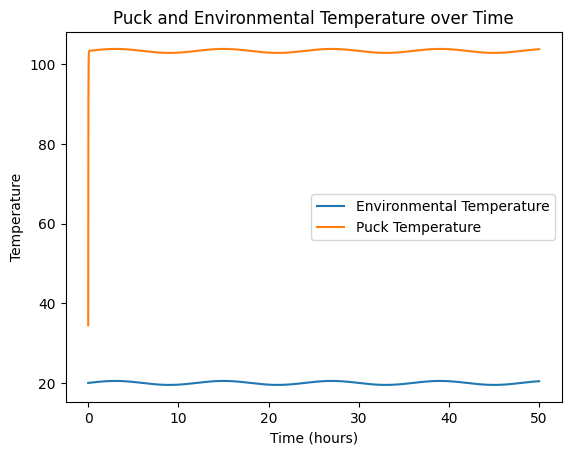

In [84]:
observation = env.reset()
done = False

Tenv_values = []
time_steps  = []
system_temperature_values = []

while not done:
    # Take a step with maxiumum heating
    action = [2] # Watts
    observation, reward, done, _ = env.step(action)

    # Append Tenv, system temperature, and time step to the lists
    Tenv_values.append(env.Tenv)
    system_temperature_values.append(observation[0])
    time_steps.append(env.time_step)

time_step_duration = env.time_step_duration
# Convert time steps to hours
time_hours = [ts * time_step_duration / 3600 for ts in time_steps]

# Plot Tenv and system temperature over time with hours on the x-axis
plt.plot(time_hours, Tenv_values, label='Environmental Temperature')
plt.plot(time_hours, system_temperature_values, label='Puck Temperature')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Puck and Environmental Temperature over Time')
plt.legend()

plt.show()


# PPO Controller

Training Stablebaseline3's Implementation of PPO on the Environment

In [85]:
# Create the vectorized environment
vec_env = DummyVecEnv([lambda: env])

# Initialize the PPO agent
ppo_agent = PPO("MlpPolicy", vec_env, verbose=1)

# Train the agent
ppo_agent.learn(total_timesteps=25000)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 811  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 663         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008806467 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 3.35e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 5.17e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0141     |
|    std                  | 0.994       |
|    value_loss           | 1.22e+06    |
-----------------

Results

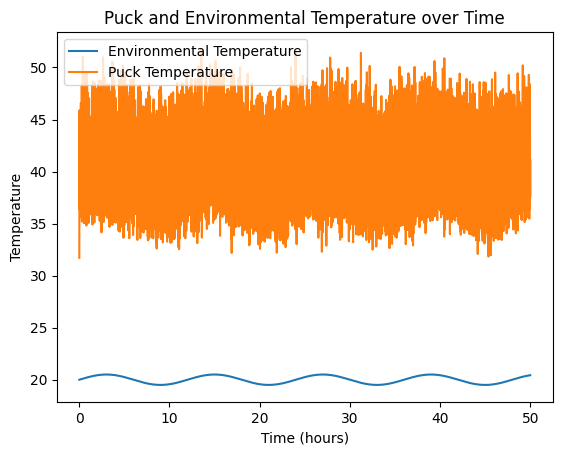

In [86]:
observation = env.reset()
done = False

Tenv_values = []
time_steps  = []
system_temperature_values = []

while not done:
    action, _ = ppo_agent.predict(observation)
    observation, reward, done, _ = env.step(action)

    # Append Tenv, system temperature, and time step to the lists
    Tenv_values.append(env.Tenv)
    system_temperature_values.append(observation[0])
    time_steps.append(env.time_step)

time_step_duration = env.time_step_duration
# Convert time steps to hours
time_hours = [ts * time_step_duration / 3600 for ts in time_steps]

# Plot Tenv and system temperature over time with hours on the x-axis
plt.plot(time_hours, Tenv_values, label='Environmental Temperature')
plt.plot(time_hours, system_temperature_values, label='Puck Temperature')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Puck and Environmental Temperature over Time')
plt.legend()

plt.show()
